In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

import keras
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.models import Model
from keras.layers import Input, Conv2D
from keras.layers import MaxPooling2D as KMaxPooling2D
from keras.utils import np_utils
 
from deconvnet.deconv2D import Deconv2D
from deconvnet.pool_unpool import MaxPooling2D, UndoMaxPooling2D
from deconvnet.forward_backward import truncated_model, backward_network

Using TensorFlow backend.


## Import images

Original images :

In [4]:
cat = plt.imread("images/cat.jpg")
cat2 = plt.imread("images/cat2.jpeg")

Images cropped to fit into VGG16 (224, 224) :

In [5]:
# sz = 224
# cat = plt.imread("images/cat.jpg")[112-sz//2:112+sz//2, 250-sz//2:250+sz//2]
# cat2 = plt.imread("images/cat2.jpeg")[112-sz//2:112+sz//2, 160-sz//2:160+sz//2]

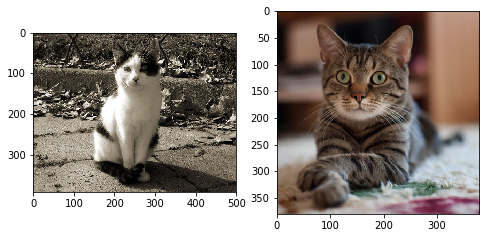

In [5]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(cat)
plt.subplot(1,2,2)
plt.imshow(cat2)
plt.show()

In [6]:
print(cat.shape, cat2.shape)

(393, 500, 3) (380, 380, 3)


## Define the networks

We define the VGG network according to the picture we want to analyze :

In [7]:
# vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=None,
#                input_shape=cat.shape, pooling=None, classes=1000)

In [8]:
vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=None,
               input_shape=cat2.shape, pooling=None, classes=1000)

We can now define the forward and backward truncated convnet and deconvnet :

In [9]:
network = truncated_model(vgg16, "block5_conv3") # Last convolutional layer
reverse_net = backward_network(network)

## Reverse propagation for sample filters

In [10]:
forward_output = network.predict(cat2[None])
_, _, _, filters = forward_output[0].shape
f0 = forward_output[0]

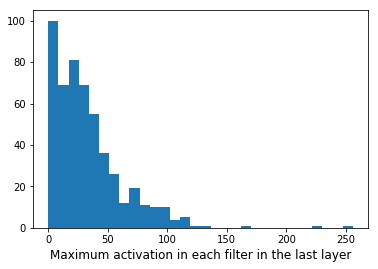

In [11]:
plt.hist(forward_output[0][0,:,:,].max(axis=(0,1)), bins=30)
plt.xlabel("Maximum activation in each filter in the last layer", fontsize=12)
plt.show()

We can see that only a small amount of filters has high activations.

Get the $k$ most activated filters :

In [12]:
print(forward_output[0][0,:,:,].max(axis=(0,1)).argsort()[:-6:-1])

[286  70 214 349 183]


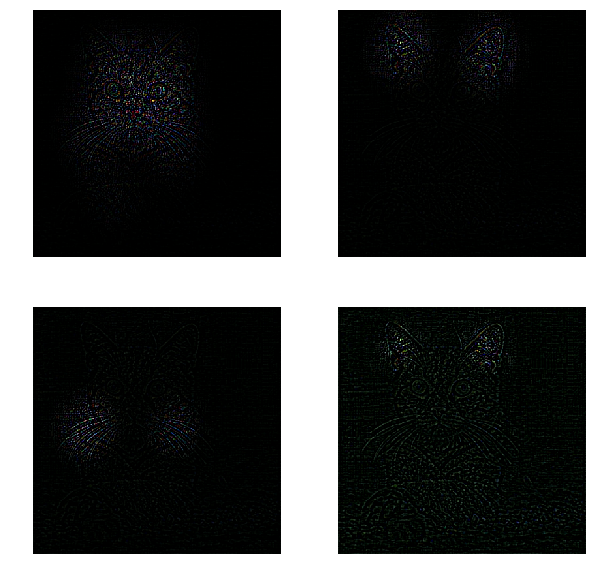

In [13]:
# Interesting filters : i = 70 for ears, 214 for mustache, 286 for face, 349 for ears again
plt.figure(figsize=(10,10))
for j, i in enumerate([286,  70, 214, 349]):
    f = f0.copy()
    forward_output[0] = f
    forward_output[0][:, :, :, np.arange(filters) != i] = 0
    backward_output = reverse_net.predict(forward_output)
    img = backward_output[0]/backward_output[0].max()
    plt.subplot(2,2,j+1)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

Check the same filters on the other cat picture (need to redefine the vgg16 network according to the image size) :

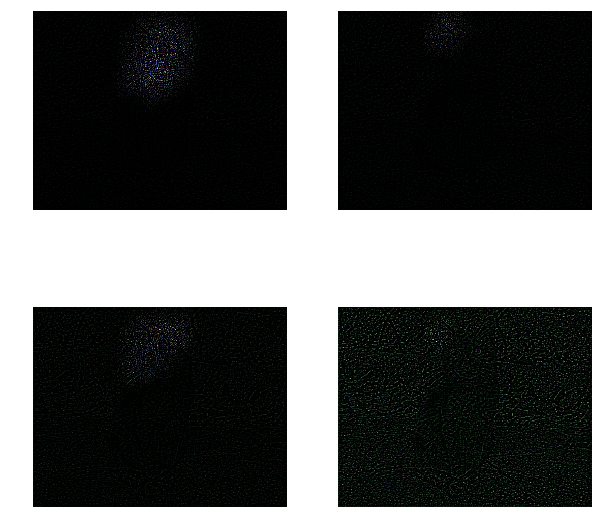

In [75]:
# Interesting filters : i = 70 for ears, 214 for mustache, 286 for face, 349 for ears again
plt.figure(figsize=(10,10))
for j, i in enumerate([286,  70, 214, 349]):
    f = f0.copy()
    forward_output[0] = f
    forward_output[0][:, :, :, np.arange(filters) != i] = 0
    backward_output = reverse_net.predict(forward_output)
    img = backward_output[0]/backward_output[0].max()
    plt.subplot(2,2,j+1)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()